Analysing protest data from Mass Mobilization Protest Data. 
Specifically, analysis of notes variable (news texts) on protests, including classification on whether protests were violent or not; the class variable (violent / non-violent) is present in the database. 

The notebook includes:
- top-level analysis of database
- LDA (Latent Dirichlet Allocation) for topic modeling - understanding themes the news on protets cover
    - on word counts & TF-IDF
- NMF (Non-negative Matrix Factorization) - for the same purpose
    - on TF-IDF
- Classification of notes - whether protest was violent or not
    - simple log regression (on tf-idf data)
    - log regression based on LSA (Latent Semantic Analysis)
    - Additionally, semantic analysis in 2 dimensional space
    - Analysis of number of dimensions and model accuracy

The database can be accessed via web page: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/HTTWYL

In [1]:
import pandas as pd
import numpy as np

# Read data

In [2]:
df = pd.read_csv('mmALL_073120_csv.csv')

In [3]:
df.shape

(17145, 31)

In [4]:
df.columns

Index(['id', 'country', 'ccode', 'year', 'region', 'protest', 'protestnumber',
       'startday', 'startmonth', 'startyear', 'endday', 'endmonth', 'endyear',
       'protesterviolence', 'location', 'participants_category',
       'participants', 'protesteridentity', 'protesterdemand1',
       'protesterdemand2', 'protesterdemand3', 'protesterdemand4',
       'stateresponse1', 'stateresponse2', 'stateresponse3', 'stateresponse4',
       'stateresponse5', 'stateresponse6', 'stateresponse7', 'sources',
       'notes'],
      dtype='object')

In [5]:
# country, startyear, participants, participants_category
df.groupby(['country', 'startyear'])['id'].count()#.to_clipboard(excel=True)

country      startyear
Afghanistan  1991.0        1
             1997.0        1
             1998.0        1
             2002.0        1
             2005.0        2
                          ..
Zimbabwe     2015.0        3
             2016.0       17
             2017.0        5
             2018.0        5
             2019.0       10
Name: id, Length: 2970, dtype: int64

In [6]:
# list of Russia protests
# df[df['country']=='Russia'].to_clipboard(excel=True)

<AxesSubplot: xlabel='startyear'>

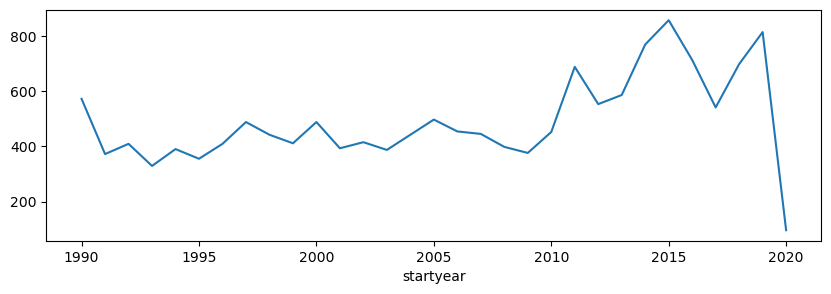

In [7]:
# check if all years are well represented
df.groupby(['startyear'])['id'].count().plot(figsize=(10,3))

Year 2020 is clearly underrepresented. Russia data has no records for 1990-91. 

In [8]:
# compare size of protests in Rus vs all (share of protests)
particip_all = df['participants_category'].value_counts(normalize=True, sort=False)
particip_rus = df[df['country']=='Russia']['participants_category'].value_counts(normalize=True, sort=False)
particip_comp = pd.concat([particip_all, particip_rus], axis=1)
particip_comp.columns=['all','rus']
round(particip_comp*100)

,all,rus
50-99,25.0,10.0
100-999,32.0,27.0
2000-4999,16.0,14.0
1000-1999,5.0,10.0
5000-10000,6.0,12.0
>10000,15.0,26.0


# LDA for notes (texts). Topic modeling

In [9]:
import nltk
import textwrap
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt

In [10]:
df[['sources','notes']].head(5)

,sources,notes
0,1. great canadian train journeys into history;...,canada s railway passenger system was finally ...
1,1. autonomy s cry revived in quebec the new yo...,protestors were only identified as young peopl...
2,1. quebec protest after queen calls for unity ...,"the queen, after calling on canadians to remai..."
3,1. indians gather as siege intensifies; armed ...,canada s federal government has agreed to acqu...
4,1. dozens hurt in mohawk blockade protest the ...,protests were directed against the state due t...


In [11]:
for col in df[['sources','notes']]:
    df[col+'_len'] = df[col].str.len()

In [12]:
df[['sources_len', 'notes_len']].describe().astype('int')

,sources_len,notes_len
count,15235,15193
mean,208,602
std,207,596
min,27,3
25%,119,215
50%,155,455
75%,238,797
max,7604,14373


In [13]:
df[['sources', 'notes']].isna().sum()

sources    1910
notes      1952
dtype: int64

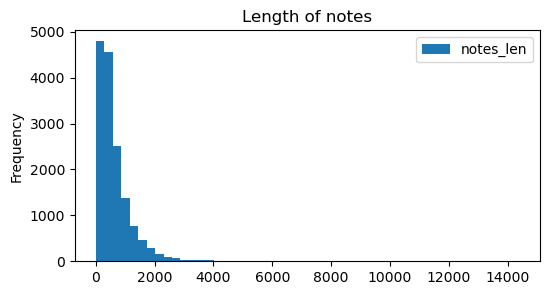

In [14]:
df[['notes_len']].plot.hist(bins=50, figsize=(6,3), title='Length of notes');

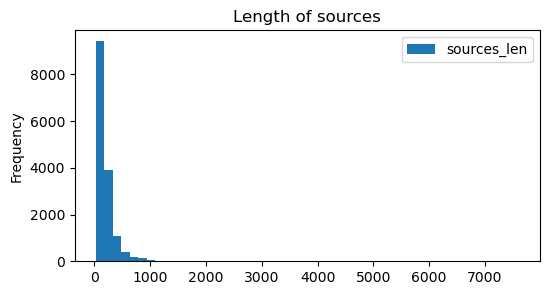

In [15]:
df[['sources_len']].plot.hist(bins=50, figsize=(6,3), title='Length of sources');

Notes seem to present richer info. But there are many duplicates in both. 

In [16]:
df[['notes']].value_counts().head(4)

notes                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

Some news appear to be duplicates. 

Let's check out how many of them are. As well as check for Nan values.

In [17]:
print(f"N of sources = {df['sources'].shape[0]}")
print(f"N of Nan sources = {df['sources'].isna().sum()}")
print(f"N of sources that are duplicated = {(df['sources'].value_counts()!=1).sum()}")
print(f"N of sources that are unique = {(df['sources'].value_counts()==1).sum()}")

N of sources = 17145
N of Nan sources = 1910
N of sources that are duplicated = 497
N of sources that are unique = 13625


In [18]:
print(f"N of notes = {df['notes'].shape[0]}")
print(f"N of Nan notes = {df['notes'].isna().sum()}")
print(f"N of notes that are duplicated = {(df['notes'].value_counts()!=1).sum()}")
print(f"N of notes that are unique = {(df['notes'].value_counts()==1).sum()}")

N of notes = 17145
N of Nan notes = 1952
N of notes that are duplicated = 333
N of notes that are unique = 13588


Overall absolute majority of news are valid ones. Let's keep the database as it is.

In [19]:
# combine notes & source into one and call it 'texts'
df['texts'] = df['sources'].fillna('') + df['notes'].fillna('')

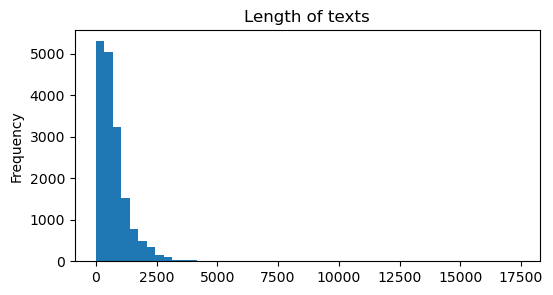

In [20]:
df['texts'].str.len().plot.hist(bins=50, figsize=(6,3), title='Length of texts');

In [21]:
print(f"N of texts = {df['texts'].shape[0]}")
print(f"N of Nan texts = {df['texts'].isna().sum()}")
print(f"N of texts that are duplicated = {(df['texts'].value_counts()!=1).sum()}")
print(f"N of texts that are unique = {(df['texts'].value_counts()==1).sum()}")

N of texts = 17145
N of Nan texts = 0
N of texts that are duplicated = 186
N of texts that are unique = 14345


- So, combined variable contains less duplciates and no Nan's, and richer data (more words). 
- However, furthere analysis show that 'sources' variable is not useful, as it contains mostlt technical, noisy info (like number of words or source name). 
- Thus, further we'll use only 'notes' variable.

In [22]:
# add stops words based on words frequency and generic words that appeared across many topics (based on further analysis)
stops = set(stopwords.words('english'))
stops = list(stops)
stops.extend(['said', '000', 'protest', 'protests', 'protesters', 'yesterday', 'mr', 'thousands', 'government', 'nan', 'people', 
                'new', 'news', 'words', 'times', 'pg', 'section', 'york', 'monday', 'march', 'tuesday', 'wednesday', 'friday', 'thursday', 'saturday',
                'column', 'city', 'sunday', 'international', 'one', 'edition', 'post', 'press', 'desk', 'world', 'day', 'presse'])

word counts

In [23]:
vectorizer = CountVectorizer(stop_words=stops)
news = df['notes'].astype('str')
X = vectorizer.fit_transform(news)

words TfIdf

In [24]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stops)
X_tf = tfidf_vectorizer.fit_transform(news)

### the most frequent words 

In [25]:
vectorizer.get_feature_names_out()

array(['00', '0000', '000cc', ..., 'zwelinzima', 'zwickel', 'zyuganov'],
      dtype=object)

In [26]:
words_freq = pd.DataFrame.sparse.from_spmatrix(X, columns=vectorizer.get_feature_names_out()).sum(axis=0)

In [27]:
words_freq.sort_values(ascending=False).head(20)

police            11401
president          3992
capital            3481
country            3260
opposition         3195
demonstrators      3130
students           3075
two                2705
streets            2673
last               2478
minister           2335
demonstration      2332
took               2231
also               2219
party              2162
hundreds           2128
several            2118
demonstrations     2115
gas                2019
national           2007
dtype: int64

## LDA model results (on counts)

In [28]:
lda = LatentDirichletAllocation(
    n_components=7, # default: 10
    random_state=12345,
)

In [29]:
lda.fit(X)

LatentDirichletAllocation(n_components=7, random_state=12345)

In [30]:
def plot_top_words(model, feature_names, title, n_top_words=10):
  n_components = len(model.components_)
  rows = int(np.ceil(n_components/5))
  fig, axes = plt.subplots(rows, 5, figsize=(20, 5*rows), sharex=True)
  axes = axes.flatten()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f"Topic {topic_idx}", fontdict={"fontsize": 15})
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=10)
    for i in "top right left".split():
        ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=15)

  fig.tight_layout()
  # plt.subplots_adjust(top=0.80, bottom=0.05, wspace=0.90, hspace=0.3)
  plt.show()

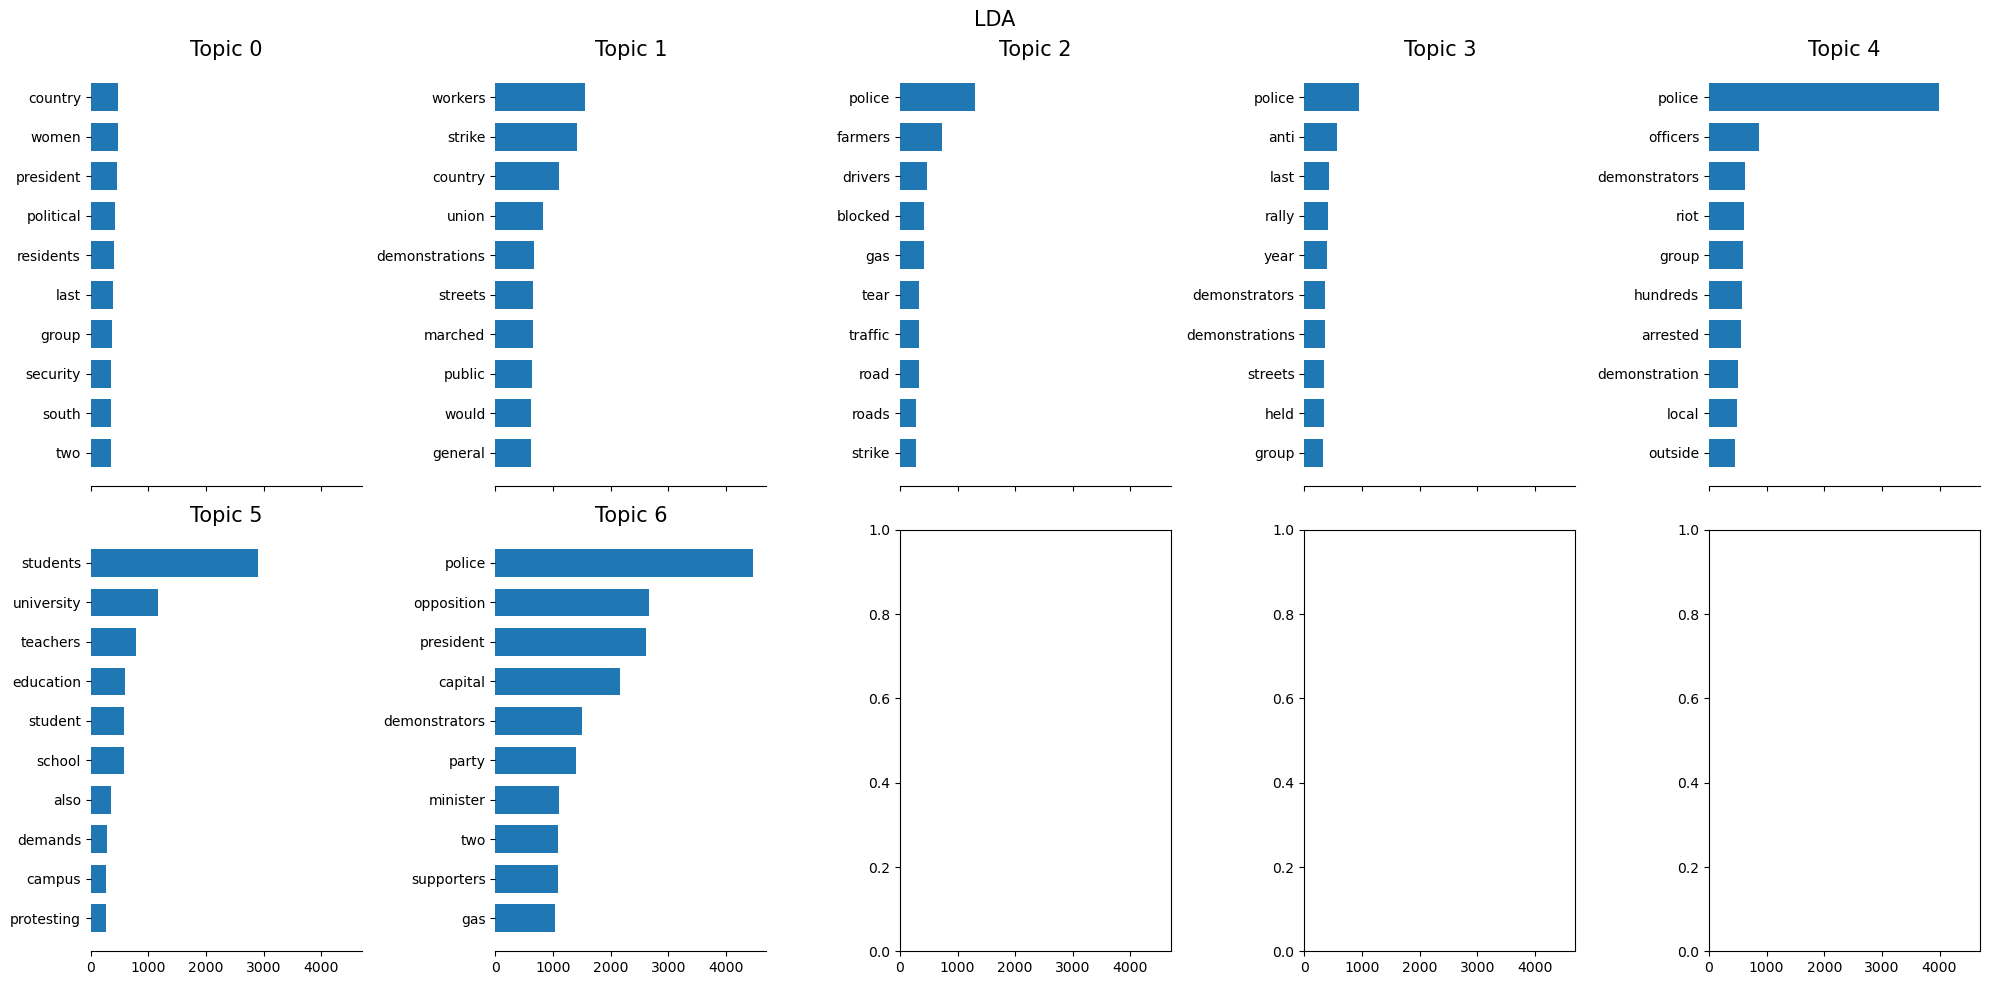

In [31]:
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, feature_names, 'LDA');

In [32]:
labels = {1: 'politics', 2: 'police vs students & residents', 3: 'police, riots', 4: 'women', 5: 'workers, strike', 6: 'strike', 7: 'police kill'}

**stopwords**: said, 000, protest, protests, protesters, yesterday, mr, thousands, government, nan, people

### model results analysis

In [33]:
Z = lda.transform(X)

In [34]:
Z.shape, news.shape

((17145, 7), (17145,))

In [35]:
np.argmax(Z, axis=1)

array([1, 3, 0, ..., 0, 0, 0])

In [36]:
df_news = pd.concat([pd.DataFrame(news), pd.DataFrame(Z)], axis=1)

In [38]:
# let's check some texts vs their LDA topics
df_news[df_news[6]>0.5]['notes'].iloc[5]

'the bush administration yesterday urged all factions in haiti s political crisis particularly the military to adhere to an agreement reached late sunday that would eventually return deposed president jean bertrand aristide to power. the agreement, worked out in negotiations at the organization of american states here between aristide and leaders of haiti s national assembly, would install a new prime minister, grant amnesty to those involved in last september s bloody coup and retain lt. gen. raoul cedras as top military commander...about 200 anti aristide demonstrators protested outside the haitian parliament yesterday carrying placards denouncing the oas agreement. demonstration organizer vladimir jeanty predicted the lawmakers who signed the agreement including senate president dejean belizaire, a coup supporter, and alexandre medard, president of the legislature would be arrested when they attempted to return to haiti today.'

## LDA model (on tfidf)

In [39]:
lda_tf = LatentDirichletAllocation(
    n_components=5, # default: 10
    random_state=12345,
)

In [40]:
lda_tf.fit(X_tf)

LatentDirichletAllocation(n_components=5, random_state=12345)

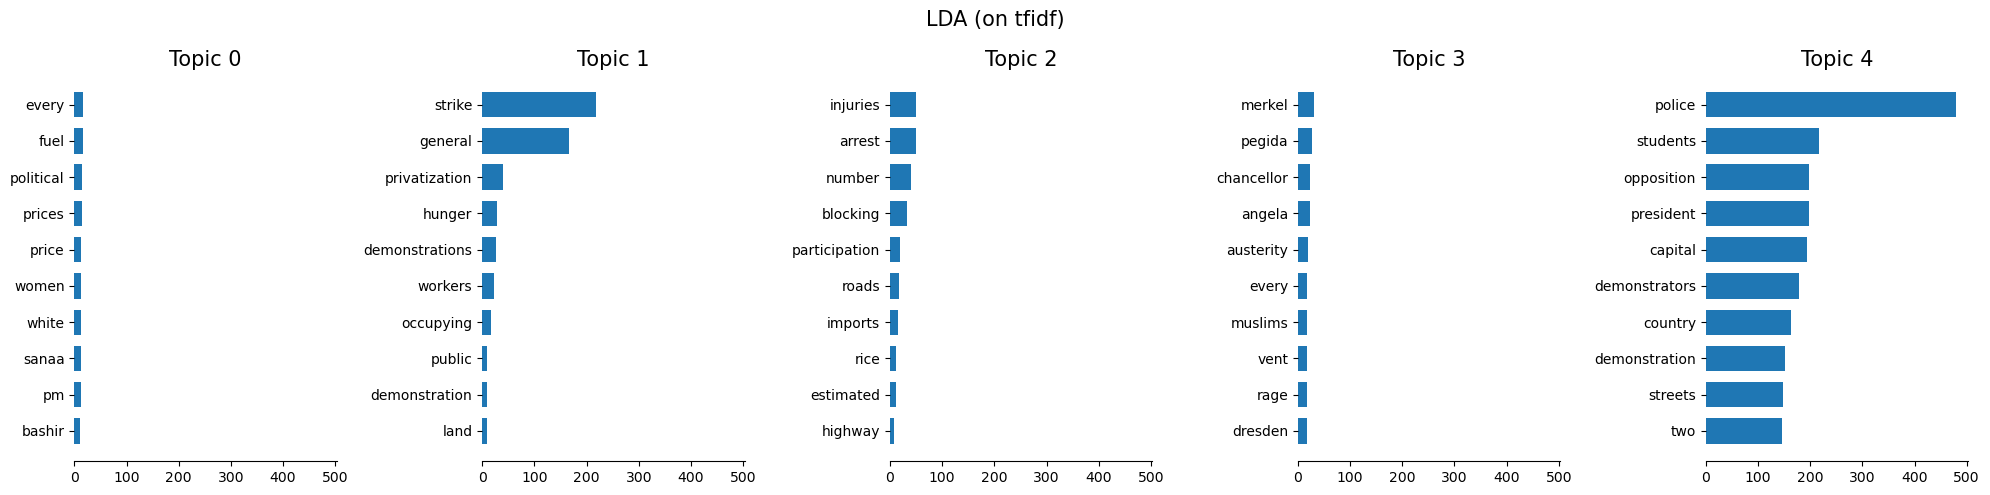

In [41]:
feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(lda_tf, feature_names, 'LDA (on tfidf)');

## NMF (non-negative matrix factorization)

In [42]:
from sklearn.decomposition import NMF

In [43]:
nmf = NMF(
    n_components=7, # default: 10
    beta_loss="kullback-leibler",
    solver='mu',
    # alpha_W=0.1,
    # alpha_H=0.1,
    # l1_ratio=0.5,
    random_state=0,
)

In [44]:
nmf.fit(X_tf)

NMF(beta_loss='kullback-leibler', n_components=7, random_state=0, solver='mu')

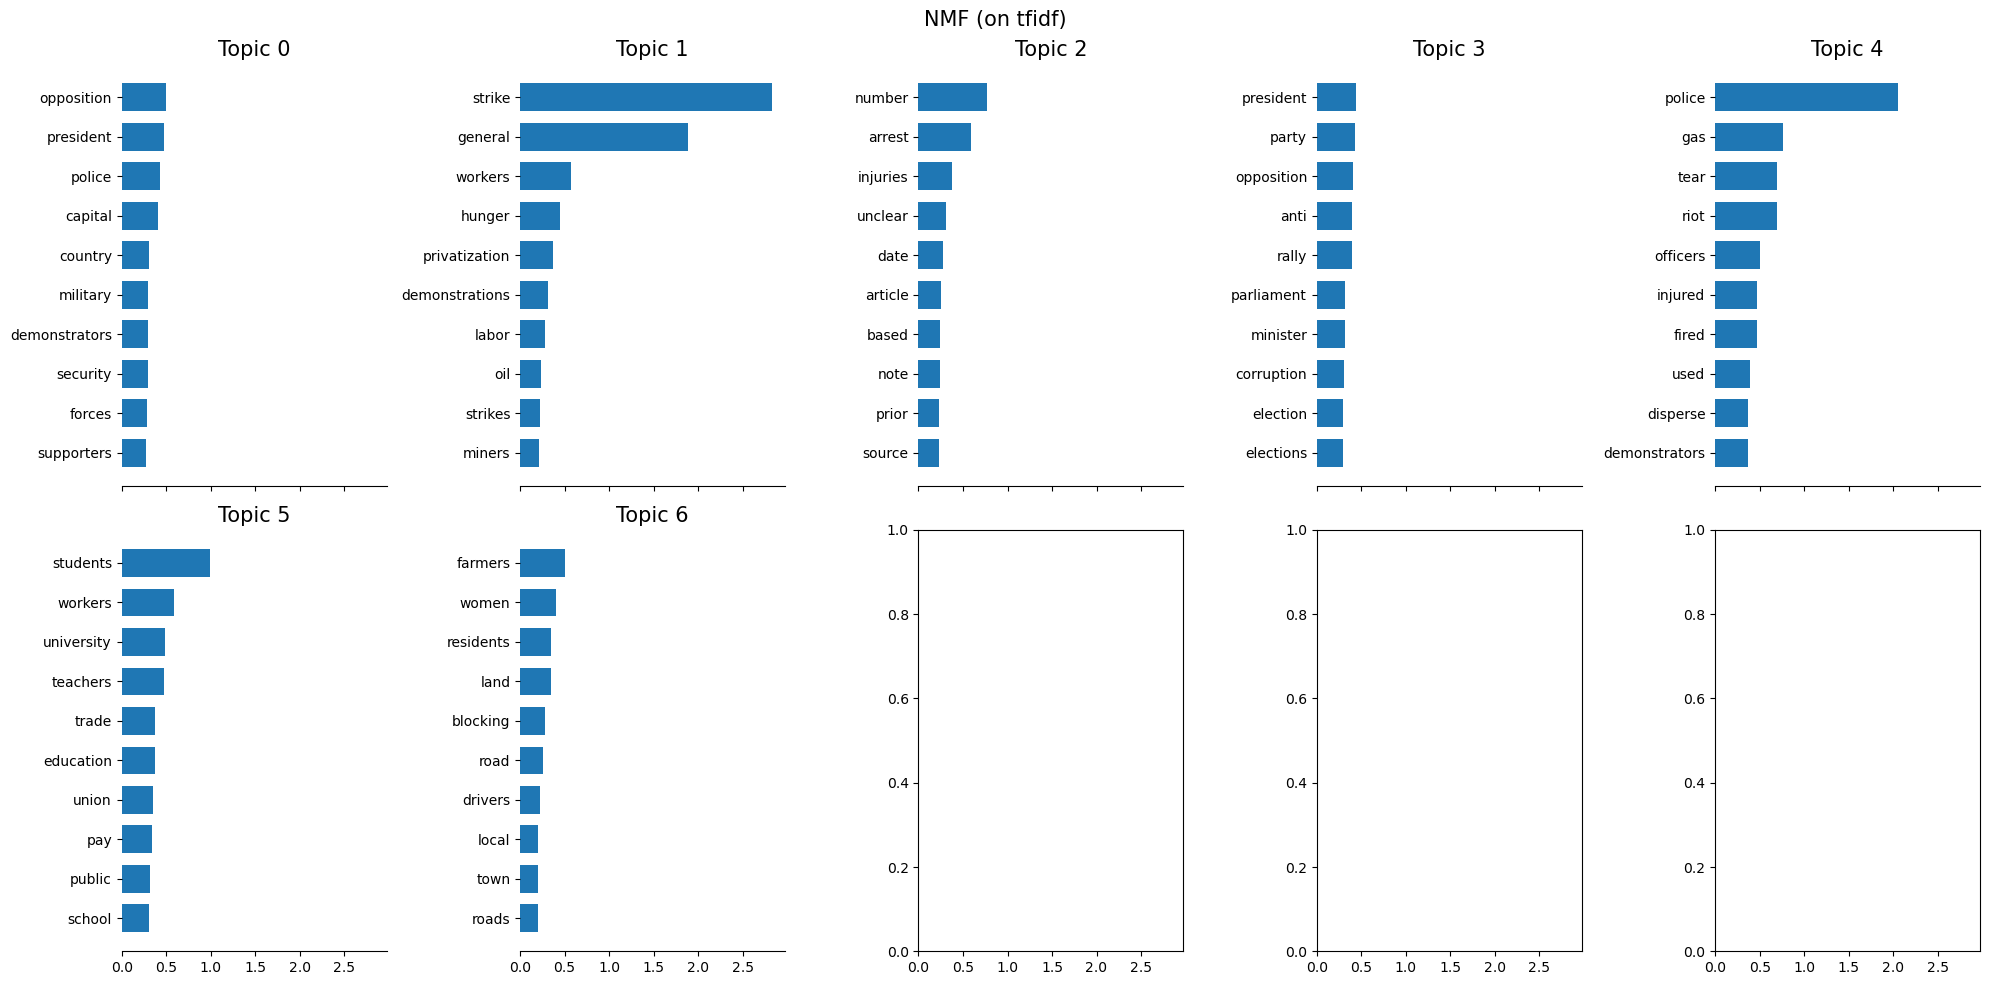

In [45]:
feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(nmf, feature_names, 'NMF (on tfidf)');

In [46]:
labels = {0: 'politics', 1: 'strike', 2: 'arrests', 3: 'anti-rally', 4: 'police', 5: 'students', 6: 'specific groups'}

In [47]:
nmf.fit(X)

NMF(beta_loss='kullback-leibler', n_components=7, random_state=0, solver='mu')

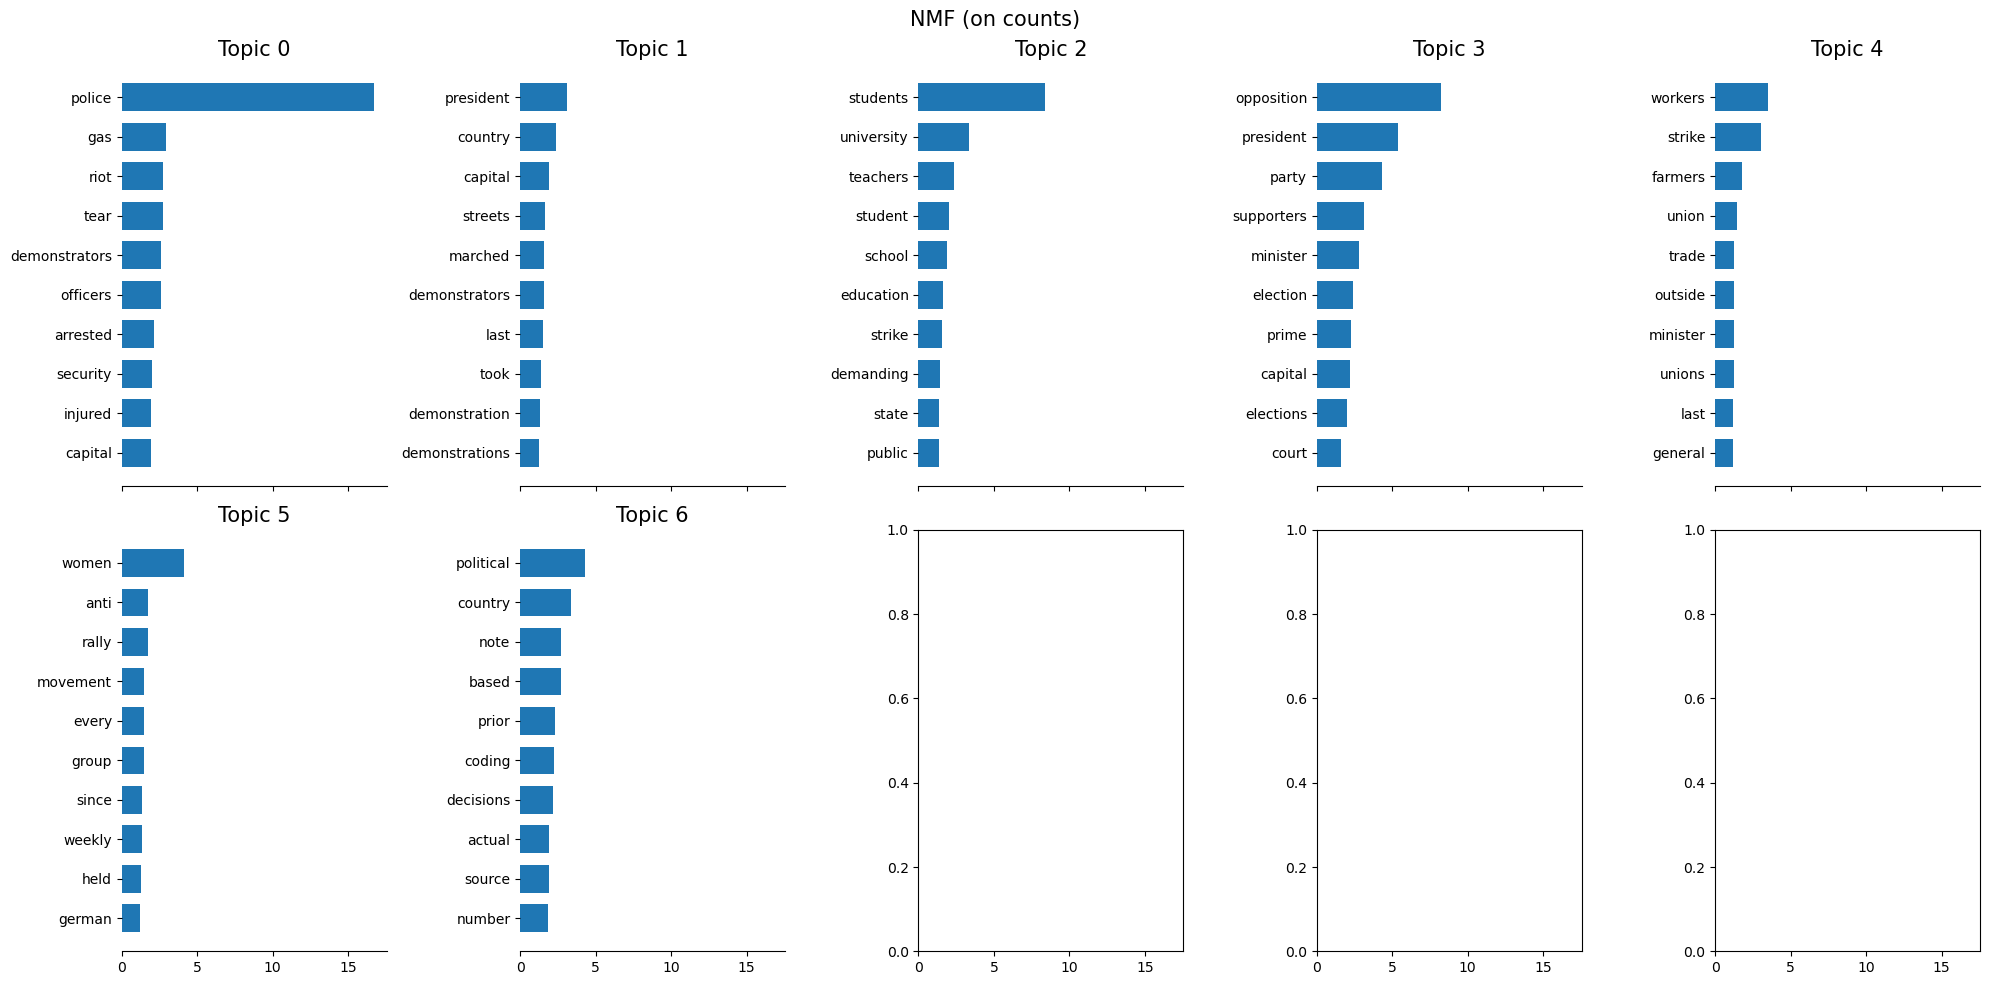

In [48]:
feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(nmf, feature_names, 'NMF (on counts)');

Результаты с TFIDF и обычным Counts кажутся довольно похожими. 

### model results analysis

In [49]:
Z = nmf.transform(X)

In [50]:
Z.shape, news.shape

((17145, 7), (17145,))

In [51]:
Z.sum(axis=1).min(), Z.sum(axis=1).max(), Z.sum(axis=1).mean()

(0.0, 3.916627549617524, 0.1675642701059735)

In [52]:
np.argmax(Z, axis=1)

array([4, 6, 4, ..., 0, 0, 0])

In [53]:
df_news = pd.concat([pd.DataFrame(news), pd.DataFrame(np.argmax(Z, axis=1))], axis=1)

In [54]:
labels = {0: 'politics', 1: 'strike', 2: 'arrests', 3: 'anti-rally', 4: 'police', 5: 'students', 6: 'specific groups'}

In [55]:
df_news.rename(columns={df_news.columns[-1]: "category"}, inplace=True)
# df_news.columnds=['notes', labels,'category']
df_news['category'].replace(labels, inplace=True)

In [56]:
df_news

,notes,category
0,canada s railway passenger system was finally ...,police
1,protestors were only identified as young peopl...,specific groups
2,"the queen, after calling on canadians to remai...",police
3,canada s federal government has agreed to acqu...,police
4,protests were directed against the state due t...,police
...,...,...
17140,peter o neill has been reappointed as prime mi...,anti-rally
17141,refugees on manus island were braced for poten...,politics
17142,nan,politics
17143,nan,politics


In [57]:
df_news.category.value_counts()

politics           5281
police             3336
strike             2706
arrests            2064
anti-rally         1971
students           1127
specific groups     660
Name: category, dtype: int64

In [58]:
df_news[df_news['category']=='anti-rally']['notes'].iloc[1026]

'more than 100,000 people turned out today under a scorching midday sun for kenya s first legal anti government demonstration in nearly a quarter century, and in an unprecedented show of defiance they cheered as the main opposition leader called for an end to the incompetent, corrupt and unimaginative government of president daniel arap moi.'

nan


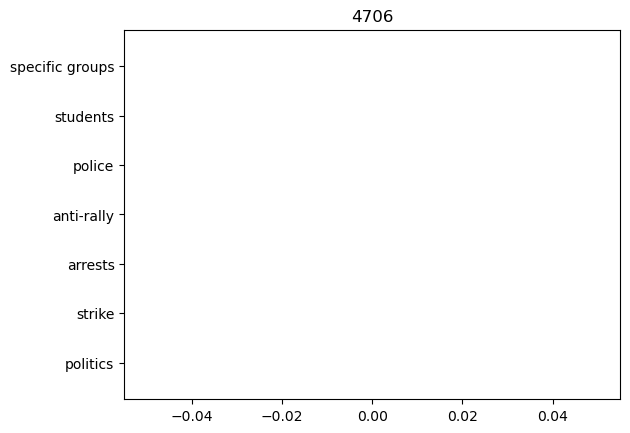

In [59]:
# Pick a random document
# Check which "topics" are associated with it
# Are they related to the true label?

i = np.random.choice(len(df_news))
z = Z[i]
topics = list(labels.values())

print(df_news['notes'].iloc[i])

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title(i);

## Classification (LogReg)

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

idea - predict from the text if there war Violence during the protest

In [61]:
# check if Nan present and classes balanced
df.protesterviolence.value_counts(dropna=False, normalize=True)

0.0    0.683756
1.0    0.235346
NaN    0.080898
Name: protesterviolence, dtype: float64

In [62]:
# Check if Nan in text (notes variable)
df.notes.isna().sum()

1952

In [63]:
# remove nan in notes and protesterviolence
df = df[~(df.notes.isna() | df.protesterviolence.isna())]

In [64]:
df.protesterviolence.value_counts(dropna=False, normalize=True)

0.0    0.73501
1.0    0.26499
Name: protesterviolence, dtype: float64

In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(df.notes, df.protesterviolence)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((11394,), (3799,), (11394,), (3799,))

In [66]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stops)

In [67]:
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

In [68]:
# add class balance (as classes are not well balancedm without it Violence is predicted much worse)
lr_model = LogisticRegression(class_weight='balanced')

In [69]:
lr_model.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced')

In [70]:
print(f'Acc for train: {lr_model.score(X_train, Y_train)}')
print(f'Acc for test: {lr_model.score(X_test, Y_test)}')

Acc for train: 0.90038616815868
Acc for test: 0.8410107923137667


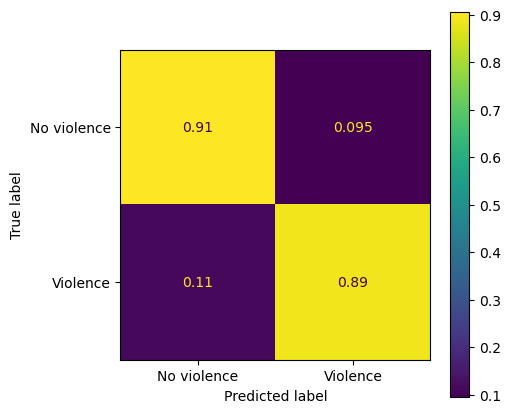

In [71]:
# cm for train
Y_train_pred = lr_model.predict(X_train)
f,ax = plt.subplots(1,1,figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(Y_train, Y_train_pred, normalize='true', display_labels=['No violence', 'Violence'], ax=ax);

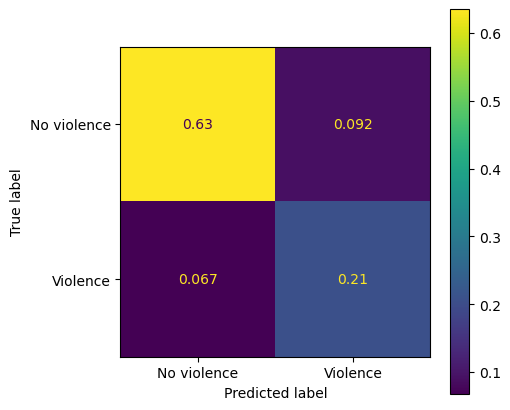

In [72]:
# cm for test 
Y_test_pred = lr_model.predict(X_test)
f,ax = plt.subplots(1,1,figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(Y_test, Y_test_pred, normalize='all', display_labels=['No violence', 'Violence'], ax=ax);

- The model performs quite fairly. On test data Violence class is identified significantly worse. 
- Let's check if dimensionality reduction can help

## Use LSA and then try log regression again

In [73]:
from sklearn.decomposition import TruncatedSVD

In [74]:
X_tf

<17145x39009 sparse matrix of type '<class 'numpy.float64'>'
	with 692145 stored elements in Compressed Sparse Row format>

#### additional exercise - see words space in 2 dimensions

In [75]:
t_svd = TruncatedSVD()

In [76]:
# reduce dimensionality for words
X_train_LSA = t_svd.fit_transform(X_train.T)
X_train_LSA.shape

(34225, 2)

In [77]:
print(f"2 dimnesions explain {round(t_svd.explained_variance_ratio_.sum(),4)*100}% of variability")

2 dimnesions explain 2.91% of variability


In [78]:
tfidf_names = tfidf_vectorizer.get_feature_names_out()

In [79]:
tfidf_names

array(['00', '0000', '000cc', ..., 'zweli', 'zwelinzima', 'zwickel'],
      dtype=object)

In [80]:
import plotly.express as px

In [81]:
fig = px.scatter(x=X_train_LSA[:,0], y=X_train_LSA[:,1], text=tfidf_names, size_max=60)
fig.update_traces(textposition='top center')
fig.show()

### prepare X data for the model

In [82]:
t_svd = TruncatedSVD(n_components=1000)

In [83]:
X_train_LSA = t_svd.fit_transform(X_train)
print(f"shape: {X_train_LSA.shape}, explained ratio: {t_svd.explained_variance_ratio_.sum()}")

shape: (11394, 1000), explained ratio: 0.523839131861849


In [84]:
X_test_LSA = t_svd.transform(X_test)
print(f"shape: {X_test_LSA.shape}")

shape: (3799, 1000)


In [85]:
Y_train.shape, Y_test.shape

((11394,), (3799,))

In [86]:
lr_model = LogisticRegression(class_weight='balanced')

In [87]:
lr_model.fit(X_train_LSA, Y_train)

LogisticRegression(class_weight='balanced')

In [88]:
print(f'Acc for train: {lr_model.score(X_train_LSA, Y_train)}')
print(f'Acc for test: {lr_model.score(X_test_LSA, Y_test)}')

Acc for train: 0.8511497279269791
Acc for test: 0.8323242958673335


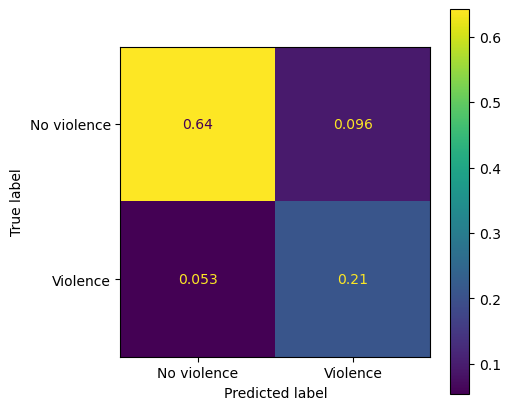

In [89]:
# cm for train
Y_train_pred = lr_model.predict(X_train_LSA)
f,ax = plt.subplots(1,1,figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(Y_train, Y_train_pred, normalize='all', display_labels=['No violence', 'Violence'], ax=ax);

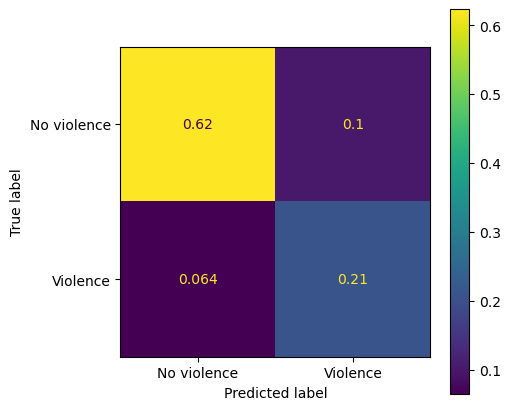

In [90]:
# cm for test 
Y_test_pred = lr_model.predict(X_test_LSA)
f,ax = plt.subplots(1,1,figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(Y_test, Y_test_pred, normalize='all', display_labels=['No violence', 'Violence'], ax=ax);

With LSA the model performs more consistently between train & test data. So probably it less reflects noise than the initial model.  

### Let's check different N of components for SVD

In [91]:
from tqdm import tqdm
import time

In [92]:
# options of N to test
n_components = [10, 50, 100, 500, 1000, 2000]
# metrics to track
explained_variance = []
accuracy_train = []
accuracy_test = []
time_loop = []

In [93]:
for n in tqdm(n_components):
    start_time = time.time()
    t_svd = TruncatedSVD(n_components=n)
    X_train_LSA = t_svd.fit_transform(X_train)
    explained_variance.append(t_svd.explained_variance_ratio_.sum())
    X_test_LSA = t_svd.transform(X_test)
    lr_model = LogisticRegression(class_weight='balanced')
    lr_model.fit(X_train_LSA, Y_train)
    accuracy_train.append(lr_model.score(X_train_LSA, Y_train))
    accuracy_test.append(lr_model.score(X_test_LSA, Y_test))
    end_time = time.time()
    time_loop.append(end_time - start_time)

100%|██████████| 6/6 [01:52<00:00, 18.68s/it]


In [94]:
lsa_res = pd.DataFrame([explained_variance, accuracy_train, accuracy_test, time_loop], columns=n_components, 
                index=['explained_variance', 'accuracy_train', 'accuracy_test', 'time_loop'])

In [95]:
for k, v in lsa_res.loc[['accuracy_test', 'time_loop'],:].T.iterrows():
    print(k, v['accuracy_test'], v['time_loop']);

10 0.78757567780995 0.22965598106384277
50 0.8094235325085549 0.575829029083252
100 0.8138983943142932 1.177361011505127
500 0.8336404316925506 9.527365922927856
1000 0.8367991576730719 24.041399240493774
2000 0.8320610687022901 76.49414992332458


/Users/oslikdau/miniforge3/envs/nlp-base/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



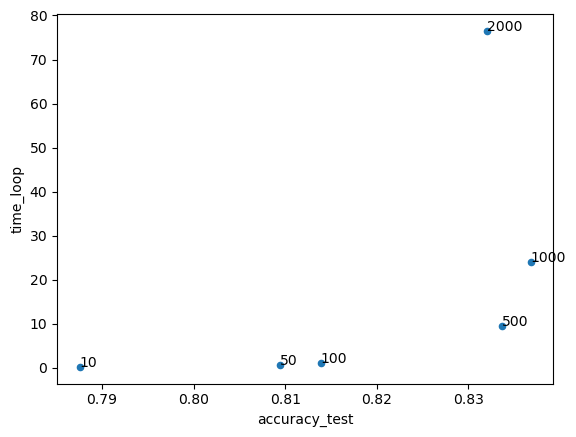

In [96]:
fig, ax = plt.subplots()
lsa_res.loc[['accuracy_test', 'time_loop'],:].T.plot.scatter('accuracy_test', 'time_loop', ax=ax)
for k, v in lsa_res.loc[['accuracy_test', 'time_loop'],:].T.iterrows():
    ax.annotate(k, (v['accuracy_test'], v['time_loop']));

In [97]:
lsa_res

,10,50,100,500,1000,2000
explained_variance,0.048709,0.115798,0.166793,0.381588,0.523849,0.687617
accuracy_train,0.777076,0.798403,0.811304,0.836581,0.851501,0.868440
accuracy_test,0.787576,0.809424,0.813898,0.833640,0.836799,0.832061
time_loop,0.229656,0.575829,1.177361,9.527366,24.041399,76.494150


After dimentionailty higher than 100 (esp 1000) accuracy on test data grows much slower than time required for computing. 

Interestingly, accuracy based on 2K dimensions appears to be worse than based on 1K dimensions. Probably, effect of additional noise in data. 